In [62]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [63]:
def f(x):
    return 3*x**2 -4*x +5

In [64]:
f(3)

20

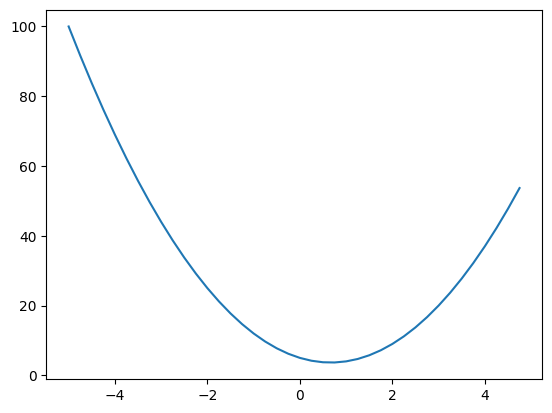

In [65]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [66]:
h = 0.00000001
x =3
(f(x+h) -f(x))/h

14.00000009255109

In [67]:
a = 2.0
b =-3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [68]:
a = 2.0
b =-3.0
c = 10.0
h= 0.0001
d1 = a*b+c

a += h
d2= a*b + c
print('d1',d1)
print ('d2',d2)
print ('slope',(d2- d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [69]:
class Value:
    def __init__(self, data, _children=(),_op='', label=""):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._op = _op
        self.label = label
        self._backward = lambda: None
    def __repr__(self):
        return (f'the value of data = {self.data}')
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other )
        out = Value(self.data + other.data, (self, other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self):
        return self * -1
    def __sub__(self,other):
        return self +(-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out= Value (self.data * other.data, (self, other),'*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __pow__(self,other):
        assert  isinstance(other,(int, float)), "only supporting int/float powers for now"
        out = Value (self.data ** other, (self,),f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        x= self.data
        out = Value (math.exp(x), (self,), label="exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x= self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out =  Value(t, (self,),label="tanh")
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out

a = Value(3,label= "a")
# print (repr(a))
# a
b = Value (-4,label="b")
c = Value(10,label="c")
# a +b # eq to : a.__add__(b)
# a *b # eq to : a.__mul__(b)
e = a*b; e.label = "e"
d =e + c; d.label = "d"# eq to : a.__mul__(b).__add__(c)
f = Value (-5, label="f")
L = d*f 
L.label= "L"
L

the value of data = 10

In [70]:
d._prev

{the value of data = -12, the value of data = 10}

In [71]:
d._op

'+'

In [72]:
from graphviz import Digraph
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot (root):
    dot= Digraph (format='svg', graph_attr={'rankdir': 'LR'}) # LR left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid=  str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name =uid, label = "{%s| data: %.4f |grad: %.4f}" % (n.label, n.data, n.grad ), shape="record")
        if n._op:
        # if this value is a result of some operation, create an op node for it
            dot.node (name= uid +n._op, label = n._op)
            # and connect this node to it.
            dot.edge (uid + n._op, uid)
    for n1, n2 in edges:
        # connect nl to the op node of n2
        dot.edge(str(id(n1)), str(id (n2)) + n2._op)
    return dot

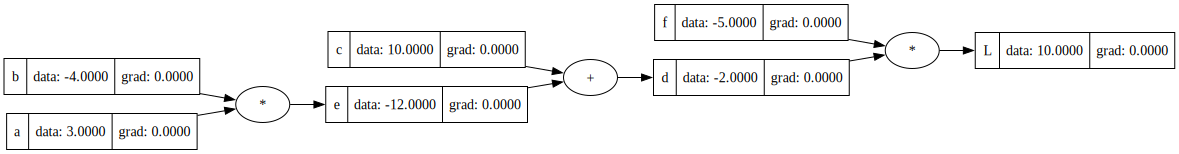

In [73]:
draw_dot(L)

Grading function : grad

In [74]:
L.grad = 1
f.grad = -2
d.grad = -5

dd / dc = 1.0

dd / de = 1.0

d = c + e

**WANT:**

dL / dc = (dL / dd) * (dd / dc)

**KNOW:**

dL / dd

dd / dc

In [75]:
# THE MOST IMPORTANT NODE
c.grad = -5
e.grad = -5

de / da = b

de / db = a

e = a * b 

**WANT:**

dL / da = (dL / dd) * (dd / de) * (de / da)

In [76]:
a.grad = 20
b.grad = -15

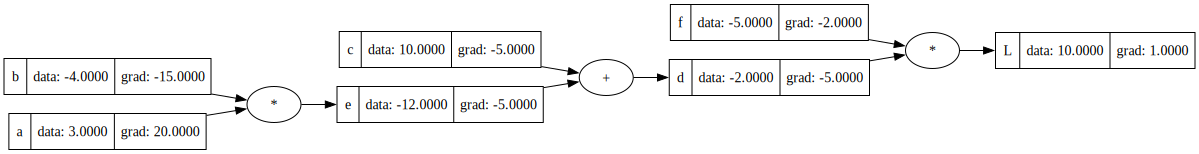

In [77]:
draw_dot(L)

In [78]:
# Single optimization step
# we are going to change the inputs to make L go up (we change in the direction of the gradient : v.grad )

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d =e + c
L = d*f 
L.data 

16.716600000000007

In [79]:
def lol():  # numerical gradient check 
    h=0.000001

    a = Value(3,label= "a")
    b = Value (-4,label="b")
    c = Value(10,label="c")
    e = a*b; e.label = "e"
    d =e + c; d.label = "d"
    f = Value (-5, label="f")
    L = d*f 
    L.label= "L"
    L1 = L.data

    a = Value(3,label= "a")
    # a.data += h
    b = Value (-4,label="b")
    b.data += h
    c = Value(10,label="c")
    # c.data+=h
    e = a*b; e.label = "e"
    d =e + c; d.label = "d"
    # d.data += h
    f = Value (-5, label="f")
    L = d*f 
    L.label= "L"
    L2 = L.data

    print ((L2 - L1)/h)


lol()

-14.999999997655777


### Manual backpropagation on a neuron
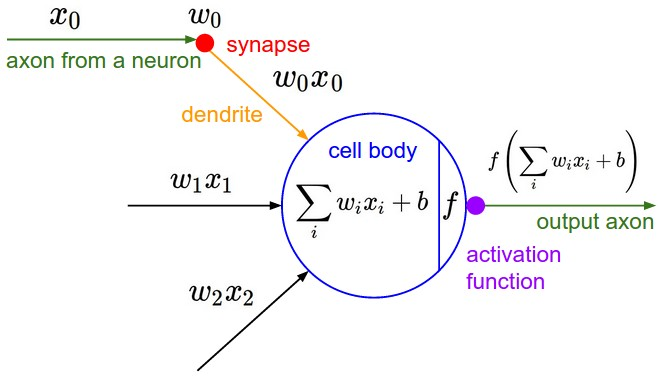

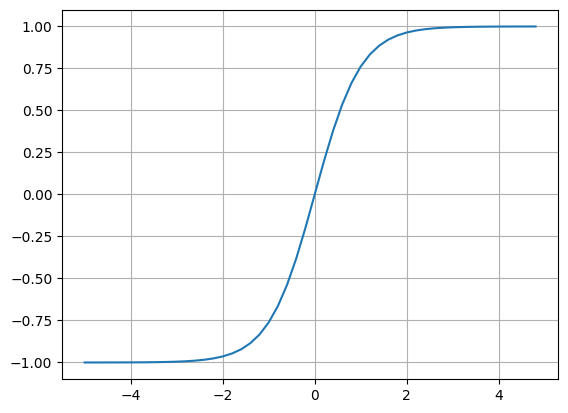

In [80]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [81]:
# inputs are x1 and x2
x1 =Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weights are w1 and w2 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias of the neuron
b = Value(6.8813735870195432, label="b")

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 +x2w2 ; x1w1x2w2.label="x1*w1+x2*w2"
n= x1w1x2w2 + b; n.label= "n"

o= n.tanh() ;o.label = "o"

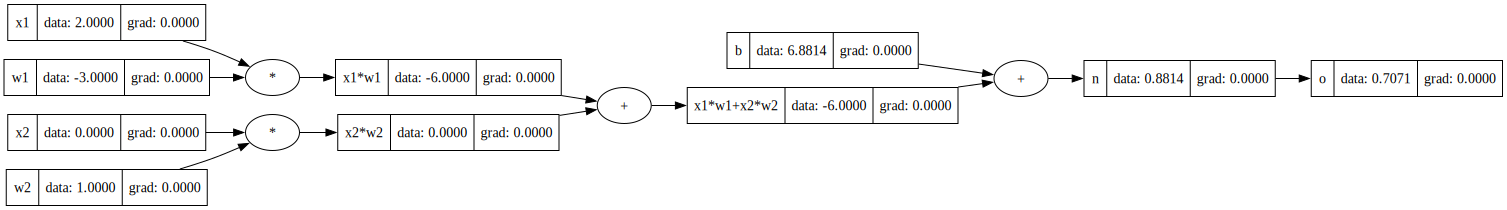

In [82]:
draw_dot(o)

In [83]:
# Manual method
o.grad= 1
n.grad = 1 - (o.data)**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

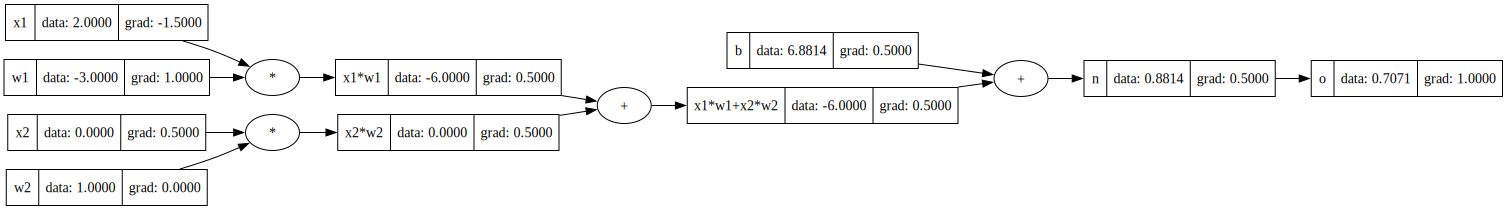

In [84]:
draw_dot(o)

### implementing backpropagation for each operation 

In [85]:
# implementation of backpropagation for each operation

# inputs are x1 and x2
x1 =Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weights are w1 and w2 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias of the neuron
b = Value(6.8813735870195432, label="b")

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 +x2w2 ; x1w1x2w2.label="x1*w1+x2*w2"
n= x1w1x2w2 + b; n.label= "n"

o= n.tanh() ;o.label = "o"

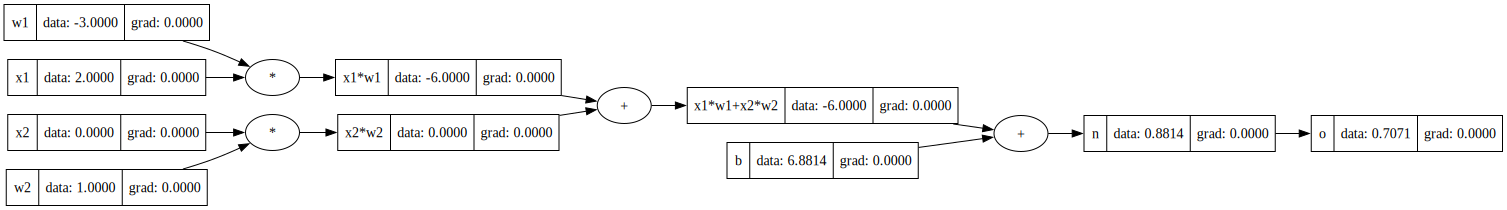

In [86]:
draw_dot(o)

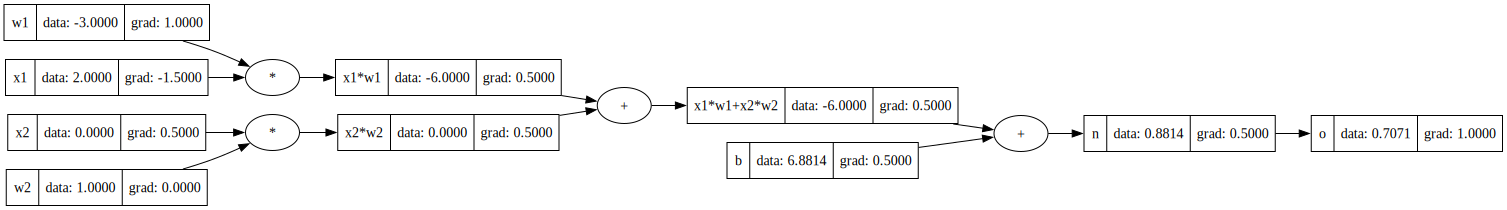

In [87]:
#backpropagation
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

### implementing the backward function for a whole expression graph
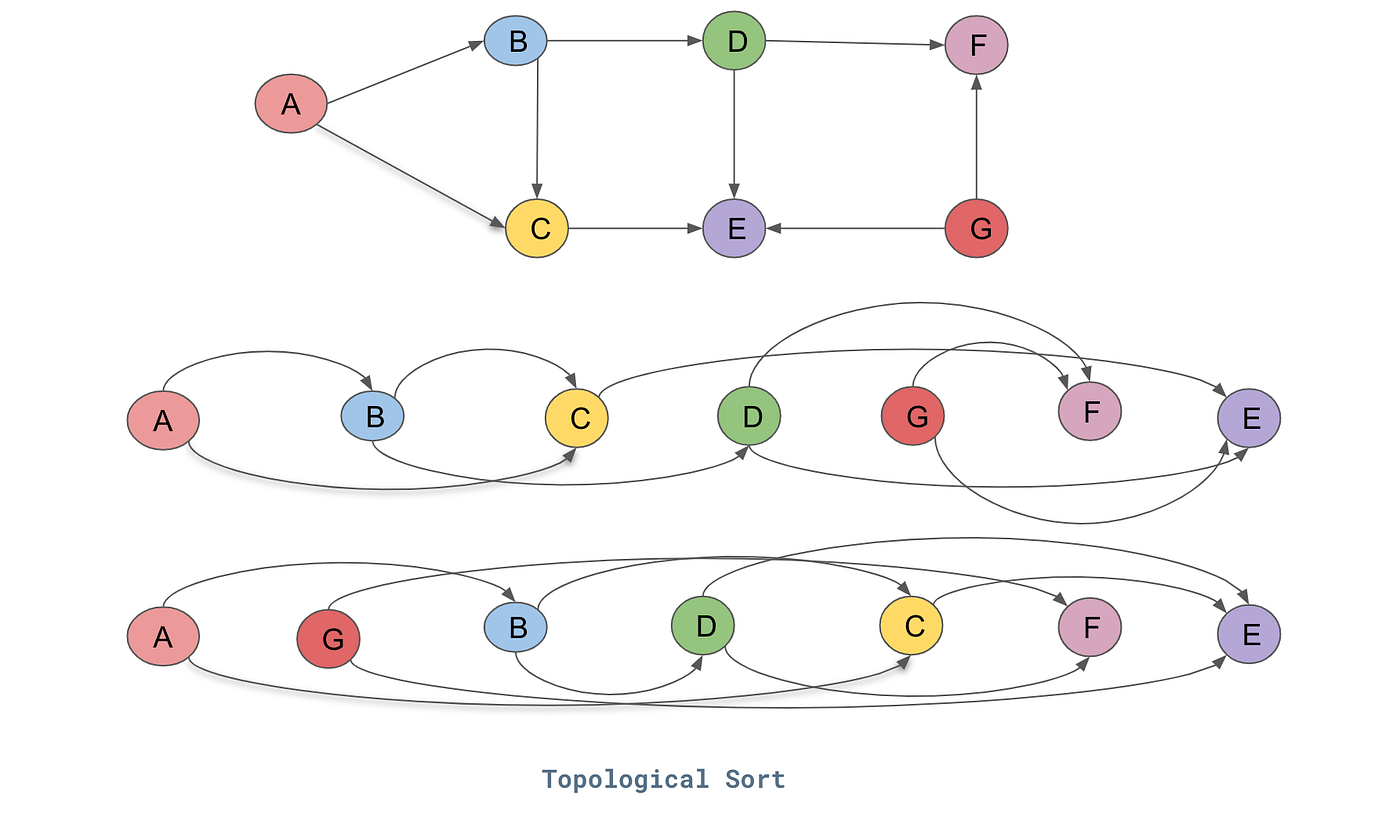


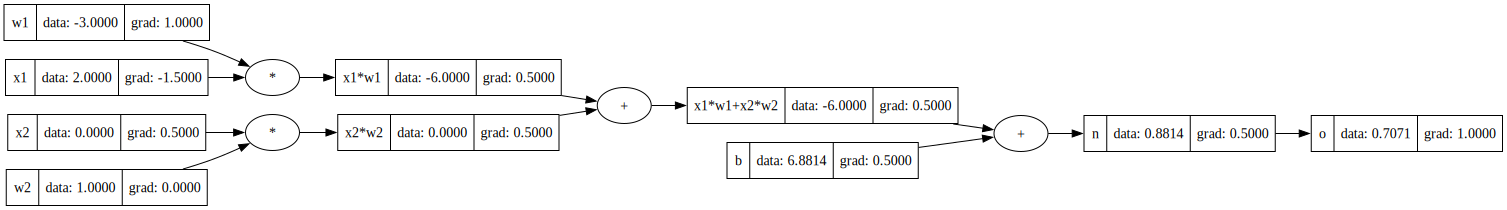

In [88]:
draw_dot(o)

In [89]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[the value of data = 6.881373587019543,
 the value of data = 2.0,
 the value of data = -3.0,
 the value of data = -6.0,
 the value of data = 0.0,
 the value of data = 1.0,
 the value of data = 0.0,
 the value of data = -6.0,
 the value of data = 0.8813735870195432,
 the value of data = 0.7071067811865476]

In [90]:
# we added backward function in Value

# inputs are x1 and x2
x1 =Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weights are w1 and w2 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias of the neuron
b = Value(6.8813735870195432, label="b")

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 +x2w2 ; x1w1x2w2.label="x1*w1+x2*w2"
n= x1w1x2w2 + b; n.label= "n"

o= n.tanh() ;o.label = "o"

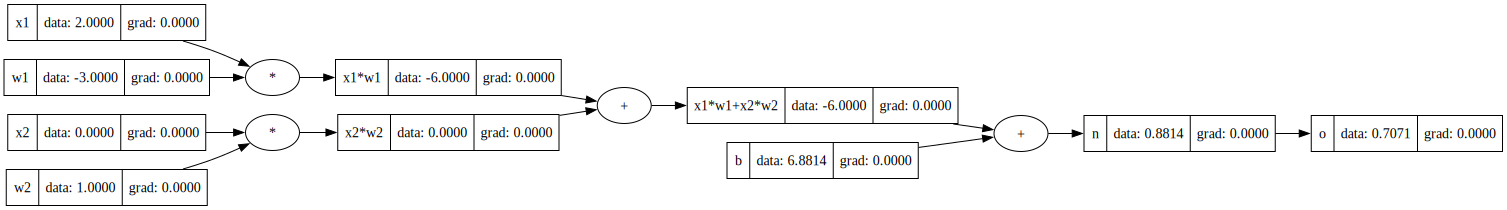

In [91]:
draw_dot(o)

In [92]:
o.backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

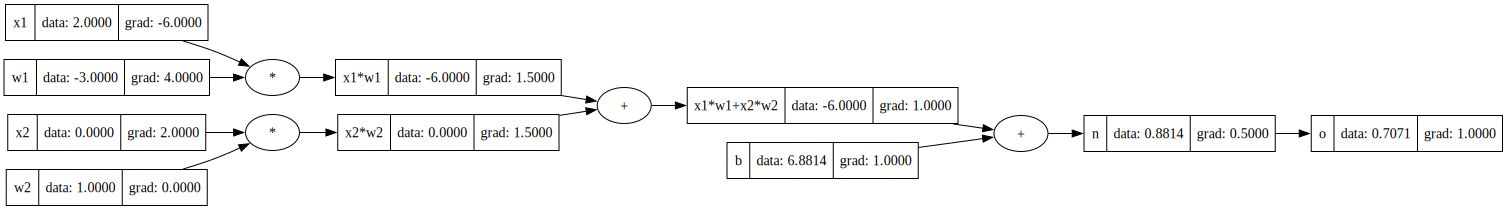

In [93]:
draw_dot(o)

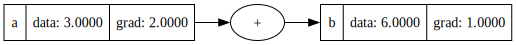

In [94]:
# fixing a backprop bug when one node is used multiple times

a = Value(3.0, label="a")
b = a + a
b.label= "b"
b.backward()
draw_dot(b) # two arrows on top of each other and the gradient is not correct (1) , should be 2
# in the Value class, the backward methods should accumulate the gradient, not just assign them, so we should use += instead of =
# and so now in the case a.grad = 2 instead of the wrong 1 at 1st

### Breaking up tanh

In [95]:
# did add neg , sub , rmul, pow, truediv methods in Value class
a = Value(2.0)
b = Value(4.0)
# a.exp()
# a/b
# a-b

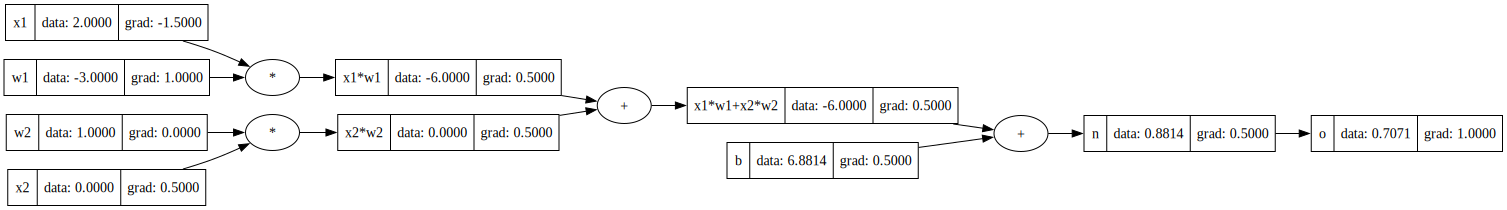

In [96]:
# inputs are x1 and x2
x1 =Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weights are w1 and w2 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias of the neuron
b = Value(6.8813735870195432, label="b")

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 +x2w2 ; x1w1x2w2.label="x1*w1+x2*w2"
n= x1w1x2w2 + b; n.label= "n"
# ---------- tanh
o = n.tanh()
o.label = "o"
# ----------
o.backward()
draw_dot(o) # we got more operation compared to before

In [97]:
# inputs are x1 and x2
x1 =Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weights are w1 and w2 
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias of the neuron
b = Value(6.8813735870195432, label="b")

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 +x2w2 ; x1w1x2w2.label="x1*w1+x2*w2"
n= x1w1x2w2 + b; n.label= "n"
# ---------- redefinig tanh
e= (2*n).exp()
o = (e-1)/(e+1)
o.label = "o"
# ----------
o.backward()

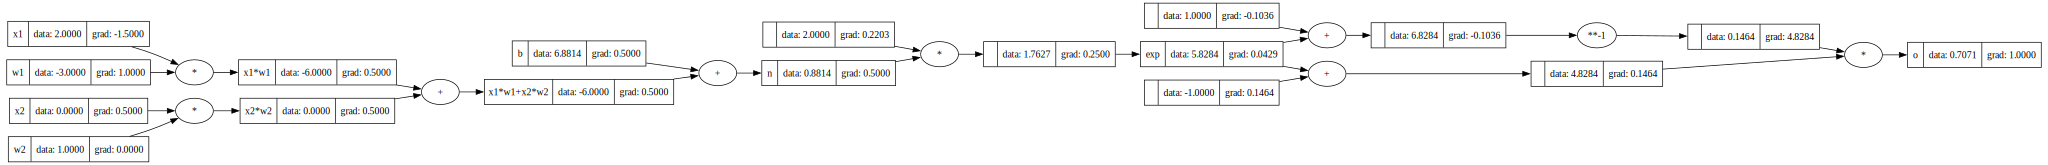

In [98]:
draw_dot(o) # we got more operation compared to before 

## Doing the same thing but in PyTorch
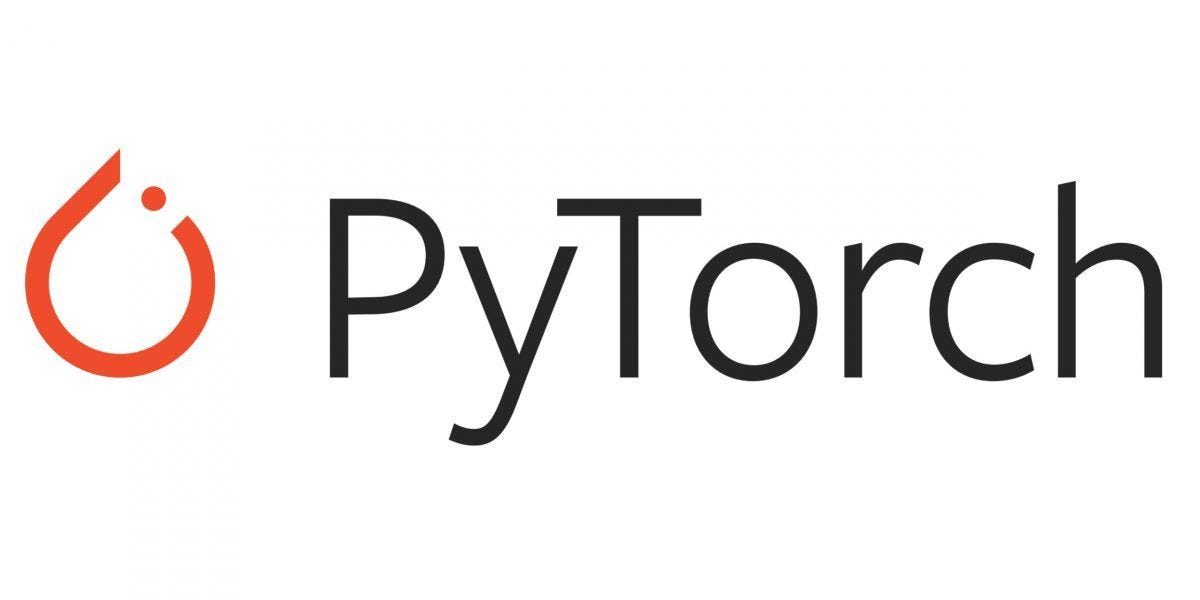

In [99]:
import torch

In [100]:
x1 = torch.tensor (2.0, requires_grad=True) # requires_grad to track all operations on it
x2= torch.tensor (0.0, requires_grad=True)
w1= torch.tensor (-3.0, requires_grad=True)
w2= torch.tensor (1.0, requires_grad=True)
b= torch.tensor (6.8813735870195432, requires_grad=True)
x1.requires_grad = True# to explicitly set requires_grad for leaf nodes
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print (o.data.item())
o.backward()    

print('------------------------torch results-----------------------')
print('x2',x2.grad.item()) #.item() to get the python number from a single-valued tensor
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071067094802856
------------------------torch results-----------------------
x2 0.5000001192092896
w2 0.0
x1 -1.5000003576278687
w1 1.000000238418579


In [101]:
torch.tensor([2.0]).double().dtype # to get the data type

torch.float64

## building out a neural net library (multi-layer perceptron) in micrograd

In [102]:
class Neuron : 
    def __init__(self, nin): # nin = number of inputs   
        self.w = [Value(np.random.uniform(-1,1)) for _ in range (nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        # zip (self.w , x) #we use zip to pair weights and inputs
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)   #activation function # sum does have a parameter to tell it where to start from = self.b
        out = act.tanh() 
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs # just to return single output instead of a list when nout=1  
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] # this simplifies the code below 
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP : 
    def __init__(self, nin, nouts): # nouts is a list of number of outputs for each layer
        sz = [nin] + nouts
        self.layers = [Layer (sz[i], sz[i+1]) for i in range (len (nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer (x)
        return x
    def parameters(self):
        return[p for layer in self.layers for p in layer.parameters()]



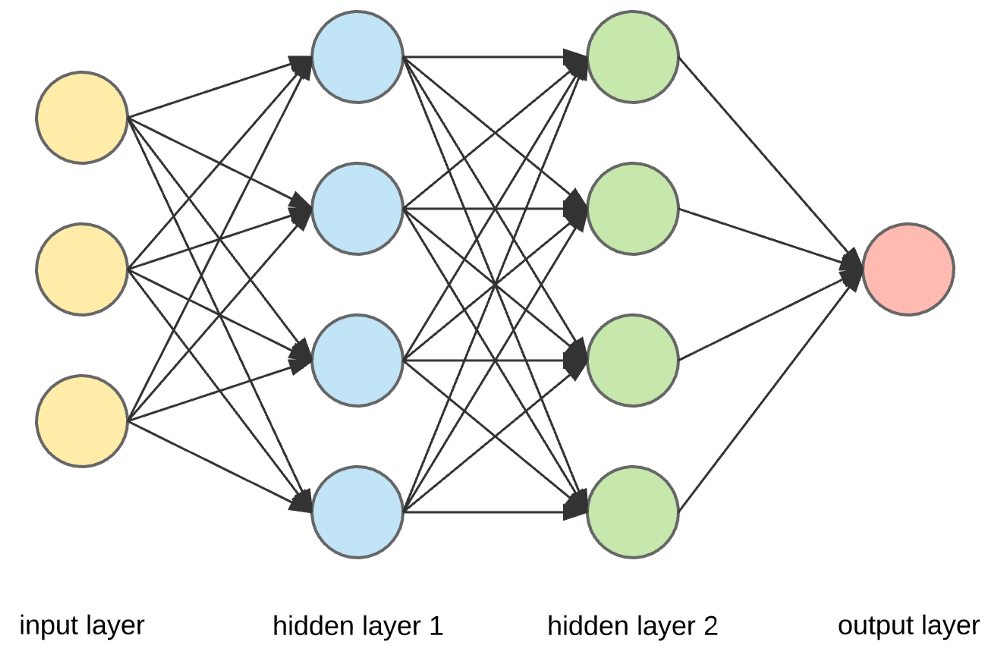

In [103]:
x = [2.0,3.0, -1.0]
# n= Neuron(2)
# n = Layer(2,3)
n = MLP(3, [4,4,1]) # multiple layer perception : 3 - 4 - 4 -1
n(x)

the value of data = 0.8664774395182452

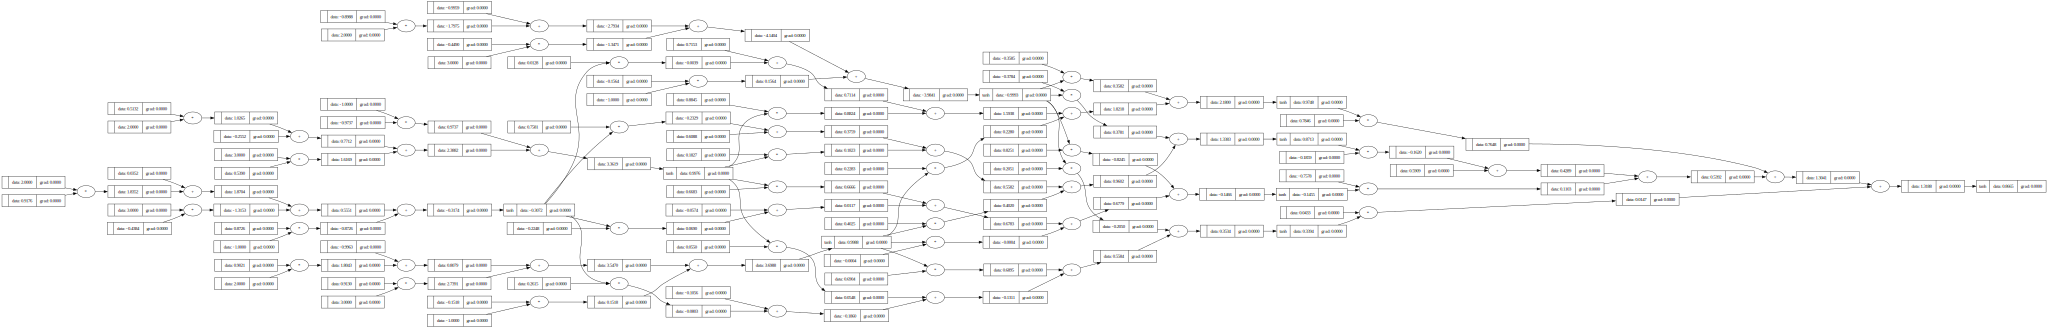

In [104]:
draw_dot(n(x))

### creating a tiny dataset, writing the loss function 

#### binary classifier neuralNet

In [105]:
n.parameters() #all the weights and biasis inside our nn 

[the value of data = 0.9175983632047375,
 the value of data = -0.43841958744368936,
 the value of data = 0.8725821202654351,
 the value of data = 0.03520929670838169,
 the value of data = 0.513235310000915,
 the value of data = 0.5389718276097919,
 the value of data = -0.9736982821634281,
 the value of data = -0.2552304554554694,
 the value of data = 0.9021413278200914,
 the value of data = 0.9130353572171321,
 the value of data = -0.1518010238103522,
 the value of data = -0.9963433385995455,
 the value of data = -0.8987500182858867,
 the value of data = -0.4490289826210092,
 the value of data = -0.15635540459843544,
 the value of data = -0.9958540608758888,
 the value of data = 0.7580792411502522,
 the value of data = 0.18274248879006838,
 the value of data = 0.40253675986072346,
 the value of data = -0.37836706337918025,
 the value of data = 0.6087676285042485,
 the value of data = -0.2247649022582603,
 the value of data = 0.668251846899067,
 the value of data = -0.000356660815064469

In [106]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0] # desired outputs for the above inputs ,  like if we feed the nn : [2.0, 3.0, -1.0] we want to get 1.0

In [107]:
y_pred = [n(x) for x in xs ]
y_pred

[the value of data = 0.8664774395182452,
 the value of data = 0.9336290219486965,
 the value of data = 0.9179679945760452,
 the value of data = 0.8667347699648134]

In [108]:
# loss function: a single number that mesure how well your nn is performing

# [(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
loss 

the value of data = 7.453110318434264

In [109]:
loss.backward()

In [110]:
print('grad = ',n.layers[0].neurons[0].w[0].grad)
print('data = ',n.layers[0].neurons[0].w[0].data)


grad =  -0.019460534682113916
data =  0.9175983632047375


### gradient descent optimization manually, training the network

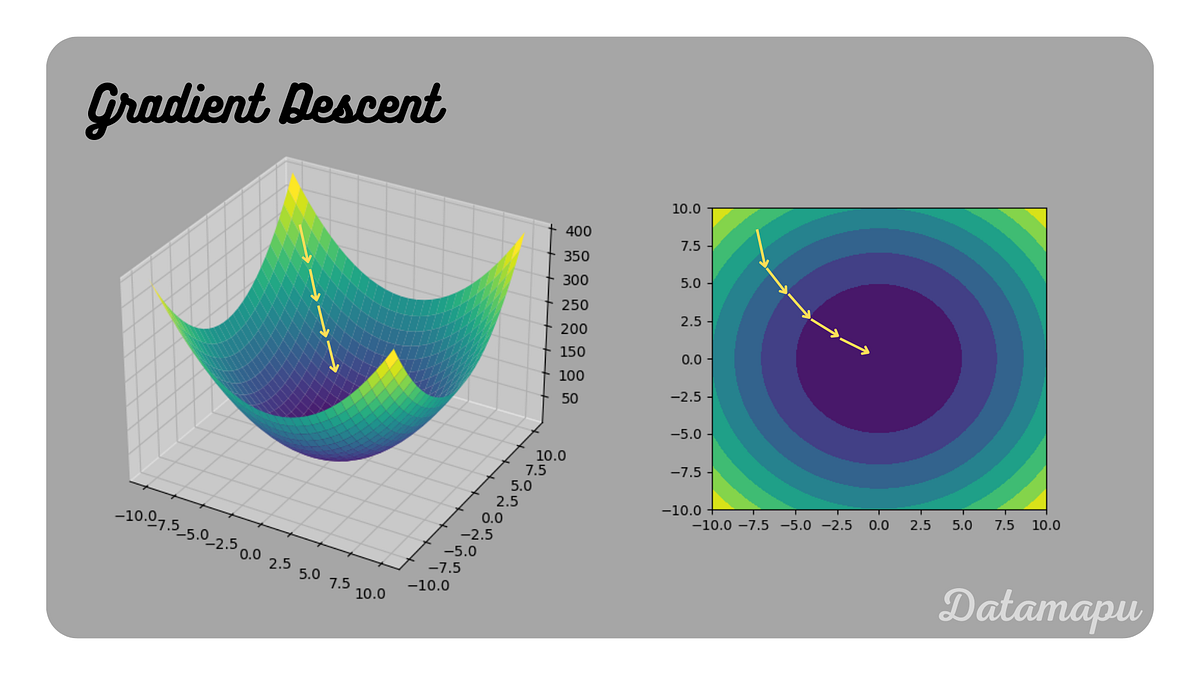

In [111]:
# before minimizing the loss , we do a step of gradient descent on all parameters
print('grad = ',n.layers[0].neurons[0].w[0].grad)
print('data = ',n.layers[0].neurons[0].w[0].data)


grad =  -0.019460534682113916
data =  0.9175983632047375


In [112]:
# Manual gradient descent step for the next 5 cells, ---ignore-- there is an automatic way after these cell
for p in n.parameters():
    p.data += -0.001 * p.grad

In [113]:
# after the step of gradient descent
print('grad = ',n.layers[0].neurons[0].w[0].grad)
print('data = ',n.layers[0].neurons[0].w[0].data)


grad =  -0.019460534682113916
data =  0.9176178237394197


In [114]:
y_pred = [n(x) for x in xs ]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)])
loss 

the value of data = 7.449455590362697

In [115]:
loss.backward()

In [116]:
y_pred

[the value of data = 0.8657736083637075,
 the value of data = 0.9331646403215599,
 the value of data = 0.9173863635168219,
 the value of data = 0.8660489919367947]

In [117]:
n.parameters()

[the value of data = 0.9176178237394197,
 the value of data = -0.43839641589697914,
 the value of data = 0.872554875724619,
 the value of data = 0.035214982619467504,
 the value of data = 0.5132981122941441,
 the value of data = 0.5387851595350304,
 the value of data = -0.9738100199934304,
 the value of data = -0.255326608823621,
 the value of data = 0.9020545086965943,
 the value of data = 0.9129822934751389,
 the value of data = -0.15188104829508456,
 the value of data = -0.9964310021443875,
 the value of data = -0.8987435427619485,
 the value of data = -0.4490200343680686,
 the value of data = -0.1563410537034912,
 the value of data = -0.9958432860374563,
 the value of data = 0.7581012966577177,
 the value of data = 0.18272974103159312,
 the value of data = 0.4025386825507045,
 the value of data = -0.37838467537013093,
 the value of data = 0.6087857743017933,
 the value of data = -0.22447221805220816,
 the value of data = 0.6681515996768305,
 the value of data = -0.00030998466738683

In [141]:
# gradient descent step should reduce the loss value,  not manually doing it for one parameter
for k in range (100):
    #forward pass
    ypred = [n(x) for x in xs ]
    loss = sum ([(yout - ygt)**2 for ygt, yout in zip (ys, ypred)])
    
    #backward pass 
    for p in n.parameters(): #Zero.grad() in pytorch
        p.grad =0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print (k, loss.data)

0 0.0005723737088255076
1 0.0005718086413514399
2 0.0005712446761009713
3 0.000570681809864505
4 0.0005701200394448779
5 0.0005695593616572716
6 0.0005689997733291795
7 0.0005684412713003469
8 0.0005678838524226897
9 0.0005673275135602544
10 0.0005667722515891683
11 0.0005662180633975565
12 0.0005656649458855029
13 0.0005651128959649869
14 0.0005645619105598173
15 0.0005640119866055984
16 0.0005634631210496598
17 0.0005629153108509988
18 0.0005623685529802101
19 0.0005618228444194733
20 0.0005612781821624668
21 0.0005607345632143016
22 0.0005601919845914991
23 0.0005596504433219206
24 0.0005591099364447048
25 0.0005585704610102342
26 0.0005580320140800814
27 0.0005574945927269109
28 0.0005569581940344956
29 0.0005564228150976287
30 0.0005558884530220565
31 0.0005553551049244543
32 0.0005548227679323809
33 0.0005542914391841804
34 0.0005537611158289819
35 0.0005532317950266339
36 0.0005527034739476451
37 0.0005521761497731226
38 0.0005516498196947792
39 0.0005511244809148017
40 0.000550

In [142]:
ypred

[the value of data = 0.9911042529248337,
 the value of data = -0.989450045123979,
 the value of data = -0.9870770807066287,
 the value of data = 0.9871984133861568]

#### summary
Neural are mathematical expression that take input as the data, the weights and the parameters of the nn, into mathematical expressions for the forward pass followed by a loss function and the loss function tries to measure the accuracy of the predictions , the lower the loss the better.
then we backward the loss using backpropagation to get the gradient and then we tune all the parameters to decrease the loss locally, and we do that process many times (gradient descent ) which minimizes the loss, so the nn do what we want it to do.
this case is only 41 parameters,  we can go for billions of params